In [ ]:
!pip install -q vllm openai datasets faiss-cpu tiktoken transformers accelerate bitsandbytes langchain langchain-community tqdm
!pip install pyzmq -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.4/326.4 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 115.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 108.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.

In [ ]:
from datasets import load_dataset
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_text_splitters import CharacterTextSplitter
from langchain_community.chat_models import ChatOpenAI
from transformers import AutoTokenizer

In [ ]:
tokenizer   = AutoTokenizer.from_pretrained("BAAI/bge-m3")
text_splitter = CharacterTextSplitter.from_huggingface_tokenizer(
    tokenizer, chunk_size=600, chunk_overlap=100
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

In [ ]:
corpus = load_dataset("yixuantt/MultiHopRAG", "corpus", split="train")

raw_docs = [
    {
        "page_content": row["body"],                        # full article text
        "metadata": {
            "doc_id"     : idx,
            "title"      : row["title"],
            "author"     : row["author"],
            "source"     : row["source"],
            "category"   : row["category"],
            "published"  : row["published_at"],
            "url"        : row["url"],
        },
    }
    for idx, row in enumerate(corpus)
]

docs = []
for d in raw_docs:
    for chunk in text_splitter.split_text(d["page_content"]):
        docs.append({ "page_content": chunk, "metadata": d["metadata"] })

print("Total chunks:", len(docs))

In [ ]:
from langchain.schema import Document
import time
lc_docs = [
    Document(page_content=d["page_content"], metadata=d["metadata"])
    for d in docs
]

embedder = HuggingFaceEmbeddings(
    model_name    = "BAAI/bge-m3",
    model_kwargs  = {"trust_remote_code": True},       # needed for FlagEmbedding wrapper
    encode_kwargs = {"normalize_embeddings": True}     # cosine‑norm like the paper
)

start_time = time.time()
vector_db = FAISS.from_documents(lc_docs, embedder)
print(f"vector_db took {time.time()-start_time:.1f}s")

<ipython-input-5-854ce5d3394e>:8: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedder = HuggingFaceEmbeddings(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

vector_db took 74.7s


In [ ]:
# python -m vllm.entrypoints.openai.api_server \
#        --model Qwen/Qwen2.5-7B-Instruct \
#        --port 8000 \
#        --max-model-len 8192

# huggingface-cli login
#
# python -m vllm.entrypoints.openai.api_server \
#        --model meta-llama/Llama-3.1-8B-Instruct \
#        --port 8000 \
#        --max-model-len 8192

In [ ]:
#vllm serve "Qwen/Qwen2.5-7B-Instruct"

In [ ]:
from langchain_community.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA
import os, tqdm, json

# -- vector → retriever
retriever = vector_db.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 4}
)

# -- LLM (point ChatOpenAI to *your* endpoint; here we assume local vLLM)
llm = ChatOpenAI(
    model            = "Qwen/Qwen2.5-7B-Instruct",                 # any string is fine for local
    # model            = "meta-llama/Llama-3.1-8B-Instruct",                 # any string is fine for local
    openai_api_base  = "http://localhost:8000/v1",
    openai_api_key   = "EMPTY",
    temperature      = 0,
    max_tokens       = 256,
)

# -- Retrieval‑augmented QA chain (stuff = simple prompt concat)
qa_chain = RetrievalQA.from_chain_type(
    llm                    = llm,
    chain_type             = "stuff",
    retriever              = retriever,
    return_source_documents= True,
)


<ipython-input-8-e86917bc6933>:12: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(


In [ ]:
sample_q= "Who is the individual associated with the cryptocurrency industry facing a criminal trial on fraud and conspiracy charges, as reported by both The Verge and TechCrunch, and is accused by prosecutors of committing fraud for personal gain?"
demo    = qa_chain(sample_q)
print("RAG ANSWER →", demo["result"])
for i, d in enumerate(demo["source_documents"], 1):
    print(f"\n[Doc {i}] {d.page_content[:200]} …")

<ipython-input-8-8ccc83fa96a6>:2: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  demo    = qa_chain(sample_q)


RAG ANSWER → The individual associated with the cryptocurrency industry facing a criminal trial on fraud and conspiracy charges is Sam Bankman-Fried. He is accused by prosecutors of committing fraud for personal gain, specifically through the misappropriation of customer funds at his former company, FTX.

[Doc 1] Come Tuesday, our eyes will be trained on the Manhattan Federal Court for the trial of Sam Bankman-Fried, the disgraced cryptocurrency entrepreneur accused of orchestrating “one of the biggest financi …

[Doc 2] Matt Huang, co-founder of Paradigm Operations LP, right, arrives at court in New York, US, on Thursday, Oct. 5, 2023. Former FTX Co-Founder Sam Bankman-Fried is charged with seven counts of fraud and  …

[Doc 3] Sam Bankman-Fried, the founder of failed cryptocurrency exchange FTX, is on trial for seven counts of wire fraud and conspiracy. FTX was a fraud “from the start,” the Securities and Exchange Commissio …

[Doc 4] Sam Bankman-Fried, the founder of failed cryptocu

In [ ]:
prefix = ("Below is a question followed by some context from different sources. "
          "Please answer the question based on the context. "
          "If the information is insufficient reply 'Insufficient Information'. "
          "Answer directly without explanation.")

# ---------------- helpers -----------------

async def rag_single(row):
    res       = await qa_chain.ainvoke(row["query"])
    retrieved = res["source_documents"]

    context = "--------------".join(d.page_content for d in retrieved)
    prompt  = f"{prefix}\n\nQuestion: {row['query']}\n\nContext:\n\n{context}"

    return {
        "query"         : row["query"],
        "prompt"        : prompt,
        "model_answer"  : res["result"],
        "question_type" : row["question_type"],
        # each retrieved chunk must carry "text"
        "retrieval_list": [
            {"text": d.page_content, "score": None} for d in retrieved
        ],
        # rename evidence_list → gold_list (script expects this)
        "gold_list"     : row["evidence_list"],
    }

async def llm_single(row):
    prompt = f"{prefix}\n\nQuestion: {row['query']}\n\nContext:\n\n"
    out    = await llm.ainvoke(row["query"])

    return {
        "query"         : row["query"],
        "prompt"        : prompt,
        "model_answer"  : out.content.strip(),
        "question_type" : row["question_type"],
        "retrieval_list": [],                 # no retrieval
        "gold_list"     : row["evidence_list"],
    }

In [ ]:
from tqdm.auto import tqdm            # notebook-/console-aware
import asyncio, json, nest_asyncio
nest_asyncio.apply()
from datasets import load_dataset
queries = load_dataset("yixuantt/MultiHopRAG", "MultiHopRAG", split="train")

batch_size = 32
# ------------- (rag_single / llm_single stay unchanged) -------------

async def run_pass(task_fn, desc, pos):
    out, batch = [], []
    pbar = tqdm(total=len(queries),
                desc=desc,
                leave=False,          # clear once done
                position=pos,         # fixed row in the notebook
                dynamic_ncols=True)   # fit cell width
    for row in queries:
        batch.append(row)
        if len(batch) == batch_size:
            out.extend(await asyncio.gather(*(task_fn(r) for r in batch)))
            pbar.update(len(batch)); batch.clear()
    if batch:                         # flush remainder
        out.extend(await asyncio.gather(*(task_fn(r) for r in batch)))
        pbar.update(len(batch))
    pbar.close()
    return out

rag_json = asyncio.run(run_pass(rag_single, "RAG",      pos=0))
llm_json = asyncio.run(run_pass(llm_single, "Pure-LLM", pos=1))

with open("qwen_rag_run.json", "w") as f:
    json.dump(rag_json, f, ensure_ascii=False, indent=2)
with open("qwen_llm_run.json", "w") as f:
    json.dump(llm_json, f, ensure_ascii=False, indent=2)

print("Saved rag_run.json and llm_run.json ✅")


MultiHopRAG.json:   0%|          | 0.00/5.17M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2556 [00:00<?, ? examples/s]

RAG:   0%|          | 0/2556 [00:00<?, ?it/s]

Pure-LLM:   0%|          | 0/2556 [00:00<?, ?it/s]

Saved rag_run.json and llm_run.json ✅


In [ ]:
!git clone -q https://github.com/yixuantt/MultiHop-RAG.git

fatal: destination path 'MultiHop-RAG' already exists and is not an empty directory.


In [ ]:
!python MultiHop-RAG/qa_evaluate.py # llama_rag_run.json

100% 2556/2556 [00:00<00:00, 15477.38it/s]
Question Type: inference_query
 Precision: 0.73
 Recall: 0.73
 F1 Score: 0.73
 accuracy: 0.65
Question Type: comparison_query
 Precision: 0.05
 Recall: 0.05
 F1 Score: 0.05
 accuracy: 0.34
Question Type: null_query
 Precision: 0.02
 Recall: 0.02
 F1 Score: 0.02
 accuracy: 0.34
Question Type: temporal_query
 Precision: 0.06
 Recall: 0.06
 F1 Score: 0.06
 accuracy: 0.35
Overall Metrics:
 Precision: 0.26
 Recall: 0.26
 F1 Score: 0.26
 Accuracy: 0.40


In [ ]:
!python MultiHop-RAG/qa_evaluate.py # qwen_rag_run.json

100% 2556/2556 [00:00<00:00, 15904.93it/s]
Question Type: inference_query
 Precision: 0.89
 Recall: 0.89
 F1 Score: 0.89
 accuracy: 0.81
Question Type: comparison_query
 Precision: 0.09
 Recall: 0.09
 F1 Score: 0.09
 accuracy: 0.35
Question Type: null_query
 Precision: 0.23
 Recall: 0.23
 F1 Score: 0.23
 accuracy: 0.39
Question Type: temporal_query
 Precision: 0.17
 Recall: 0.17
 F1 Score: 0.17
 accuracy: 0.38
Overall Metrics:
 Precision: 0.38
 Recall: 0.38
 F1 Score: 0.38
 Accuracy: 0.45


In [ ]:
!python MultiHop-RAG/qa_evaluate.py # llama_llm_run.json

100% 2556/2556 [00:00<00:00, 15763.12it/s]
Question Type: inference_query
 Precision: 0.33
 Recall: 0.33
 F1 Score: 0.33
 accuracy: 0.43
Question Type: comparison_query
 Precision: 0.01
 Recall: 0.01
 F1 Score: 0.01
 accuracy: 0.34
Question Type: null_query
 Precision: 0.00
 Recall: 0.00
 F1 Score: 0.00
 accuracy: 0.33
Question Type: temporal_query
 Precision: 0.02
 Recall: 0.02
 F1 Score: 0.02
 accuracy: 0.34
Overall Metrics:
 Precision: 0.11
 Recall: 0.11
 F1 Score: 0.11
 Accuracy: 0.36


In [ ]:
!python MultiHop-RAG/qa_evaluate.py # qwen_llm_run.json

100% 2556/2556 [00:00<00:00, 15290.82it/s]
Question Type: inference_query
 Precision: 0.64
 Recall: 0.64
 F1 Score: 0.64
 accuracy: 0.58
Question Type: comparison_query
 Precision: 0.03
 Recall: 0.03
 F1 Score: 0.03
 accuracy: 0.34
Question Type: null_query
 Precision: 0.04
 Recall: 0.04
 F1 Score: 0.04
 accuracy: 0.34
Question Type: temporal_query
 Precision: 0.11
 Recall: 0.11
 F1 Score: 0.11
 accuracy: 0.36
Overall Metrics:
 Precision: 0.25
 Recall: 0.25
 F1 Score: 0.25
 Accuracy: 0.40


In [ ]:
# !unzip Louvain-Algorithm-Without-Graph-Construction-main.zip

In [ ]:
import numpy as np, math, torch

n_total = vector_db.index.ntotal      # how many chunks are in the store
dim     = vector_db.index.d

vecs = np.empty((n_total, dim), dtype=np.float32)
for i in range(n_total):
    vecs[i] = vector_db.index.reconstruct(i)  # O(N·dim) but pure C++ → fast

print(f"Pulled {n_total} vectors of dim {dim} from FAISS.")

norms = np.linalg.norm(vecs, axis=1)
print(f"‖v‖₂  (mean / min / max):  {norms.mean():.4f} / {norms.min():.4f} / {norms.max():.4f}")
assert np.allclose(norms, 1.0, atol=1e-4), "Embeddings not unit-normalised!"

Pulled 3320 vectors of dim 1024 from FAISS.
‖v‖₂  (mean / min / max):  1.0000 / 1.0000 / 1.0000


In [ ]:
vecs_h = np.hstack([vecs, np.ones((n_total, 1), dtype=np.float32)]) / math.sqrt(2)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
X = torch.from_numpy(vecs_h).to(device)
print(f"Tensor for Louvain: {X.shape}, dtype={X.dtype}, device={X.device}")

Tensor for Louvain: torch.Size([3320, 1025]), dtype=torch.float32, device=cuda:0


In [ ]:
# from my_louvain.src.main_algorithm import *
import time
from tqdm import tqdm

In [ ]:
def node_degrees(matrix):
    # Sum up the entire matrix into a single row vector
    row_sums = torch.sum(matrix, dim=0)

    # Calculate the degrees for each node
    degrees = torch.matmul(matrix, row_sums) - torch.sum(matrix * matrix, dim=1)

    return degrees

def calculate_m(degrees):
    return torch.sum(degrees) / 2

def initialize_communities(matrix, shuffle=True, seed=42):
    num_nodes = matrix.shape[0]

    # Initialize community assignments: each node in its own community
    community_assignments = torch.arange(num_nodes)

    # Initialize visiting order
    if shuffle:
        torch.manual_seed(seed)
        visit_order = torch.randperm(num_nodes)
    else:
        visit_order = torch.arange(num_nodes)

    return community_assignments, visit_order

def optimized_community(matrix, community_matrix, degrees, community_degrees, m, gamma, community_assignments, vertex_index):
    X_i = matrix[vertex_index]
    k_i = degrees[vertex_index]

    # Compute the inner product of X_i with the community matrix
    inner_products = torch.matmul(X_i, community_matrix.t())

    # Compute degree contributions
    degree_contributions = gamma * k_i * community_degrees / (2 * m)

    # Compute Q contributions for all communities
    Q_contributions = inner_products - degree_contributions

    # Handle the case where i is in its current community
    current_community = community_assignments[vertex_index]
    same_community_mask = (community_assignments == current_community)
    Q_contributions[same_community_mask] -= (torch.dot(X_i, X_i) - gamma * (k_i ** 2) / (2 * m))

    # Find the optimal community and the corresponding delta Q
    optimal_community_index = torch.argmax(Q_contributions)
    optimal_community = community_assignments[optimal_community_index]
    delta_Q = Q_contributions[optimal_community_index] - Q_contributions[vertex_index]

    if optimal_community != current_community:
        # Update the community assignments
        community_assignments[vertex_index] = optimal_community

        # Update the community matrix and degrees for current and optimal communities
        community_matrix[same_community_mask] -= X_i
        community_matrix[community_assignments == optimal_community] += X_i
        community_matrix[vertex_index] = community_matrix[optimal_community_index]

        community_degrees[same_community_mask] -= k_i
        community_degrees[community_assignments == optimal_community] += k_i
        community_degrees[vertex_index] = community_degrees[optimal_community_index]

    return optimal_community.item(), delta_Q.item() / (2 * m)

def one_level(matrix, degrees, m, gamma, seed=42):
    # Initialize communities and visiting order
    community_assignments, visit_order = initialize_communities(matrix, shuffle=True, seed=seed)
    community_matrix = matrix.clone()
    community_degrees = degrees.clone()
    total_Q = torch.tensor(0.0, device=matrix.device)

    # Move community_assignments and visit_order to the same device as matrix
    community_assignments = community_assignments.to(matrix.device)
    visit_order = visit_order.to(matrix.device)

    # Iterate through the visit order with a progress bar
    for vertex_index in tqdm(visit_order, desc="Processing nodes"):
        # Get the optimal community and delta Q
        optimal_community, delta_Q = optimized_community(matrix, community_matrix, degrees, community_degrees, m, gamma, community_assignments, vertex_index)

        # Update community assignments and total modularity
        community_assignments[vertex_index] = optimal_community
        total_Q += delta_Q

    # Retrieve unique communities and their corresponding rows in the community matrix
    unique_communities, indices = torch.unique(community_assignments, return_inverse=True)
    unique_community_indices = torch.tensor([torch.where(community_assignments == u)[0][0] for u in unique_communities], device=matrix.device)
    unique_community_matrix = community_matrix[unique_community_indices]
    unique_community_degrees = community_degrees[unique_community_indices]

    new_community_assignments = indices

    # Create a dictionary for the output
    result = {
    "num_communities": len(unique_communities),
    "total_Q": total_Q.item(),
    "community_assignments": new_community_assignments,
    "unique_community_matrix": unique_community_matrix,
    "unique_community_degrees": unique_community_degrees
}

    return result

def louvain_partition(matrix, gamma=1.0, threshold=1e-7, max_level=-1, seed=42, print_layer_result=False):
    # Initialize degrees and modularity
    degrees = node_degrees(matrix)
    m = calculate_m(degrees)
    total_modularity = 0.0

    # Store results
    partitions = []

    # Start with the original matrix
    current_matrix = matrix
    current_degrees = degrees
    current_gamma = gamma
    current_m = m

    while True:
        # Call one_level function
        result = one_level(current_matrix, current_degrees, current_m, current_gamma, seed)

        # Extract the results
        num_communities = result["num_communities"]
        delta_Q = result["total_Q"]
        community_assignments = result["community_assignments"]
        unique_community_matrix = result["unique_community_matrix"]
        unique_community_degrees = result["unique_community_degrees"]

        # Print layer results if needed
        if print_layer_result:
            print(f"Number of communities: {num_communities}, Delta Q: {delta_Q}")
            print(torch.unique(unique_community_matrix, dim=0).shape)
        # Update total modularity
        total_modularity += delta_Q

        # Append the current community assignments
        partitions.append(community_assignments)

        # Check for termination condition
        if delta_Q <= threshold or (max_level > 0 and len(partitions) >= max_level):
            break

        # Update the current matrix and degrees for the next level
        current_matrix = unique_community_matrix
        # current_degrees = node_degrees(current_matrix)
        current_degrees = unique_community_degrees

    return partitions

def get_final_communities(partitions):
    """
    Given a list of partitions from the Louvain algorithm, map the original nodes to their final communities.

    Parameters:
    - partitions (list of torch.Tensor): List of partition tensors, where each tensor represents
      the community assignments at a given level of the algorithm.

    Returns:
    - torch.Tensor: A tensor of community assignments for the original nodes.
    """
    # Start with the last partition (the most reduced one)
    final_partition = partitions[-1]
    # Iterate backwards through the partitions to map to original nodes
    for partition in reversed(partitions[:-1]):
        final_partition = final_partition[partition]

    return final_partition

def modularity_single_community(matrix, degrees, m):
    """
    Calculate the modularity for a single community.

    Parameters:
    - matrix (torch.Tensor): The input adjacency matrix.
    - degrees (torch.Tensor): The degree vector.
    - m (float): The total weight of the graph.

    Returns:
    - float: The modularity of the single community.
    """
    # Calculate community row (sum of matrix rows corresponding to the community)
    community_row = torch.sum(matrix, dim=0)

    # Calculate community degree
    community_degree = torch.sum(degrees)

    # Calculate the modularity
    inner_product_community = torch.dot(community_row, community_row)
    degree_contribution = (community_degree ** 2) / (2 * m)

    modularity = inner_product_community - degree_contribution

    # Calculate the self-interaction part
    self_interaction = torch.dot(matrix.flatten(), matrix.flatten().t())
    self_interaction -= torch.dot(degrees, degrees) / (2 * m)

    # Subtract self-interaction and normalize by 2m
    modularity -= self_interaction
    modularity /= 2 * m

    return modularity.item()

def modularity_all_partitions(matrix, partitions):
    """
    Calculate the modularity for all partitions.

    Parameters:
    - matrix (torch.Tensor): The input adjacency matrix.
    - partitions (torch.Tensor): The partition vector indicating community assignments.
    - degrees (torch.Tensor): The degree vector.
    - m (float): The total weight of the graph.

    Returns:
    - float: The total modularity for all partitions.
    """
    degrees = node_degrees(matrix)
    m = calculate_m(degrees)

    unique_communities = torch.unique(partitions)
    total_modularity = 0.0

    for community in unique_communities:
        community_mask = (partitions == community)
        community_matrix = matrix[community_mask]
        community_degrees = degrees[community_mask]
        # print(modularity_single_community(community_matrix, community_degrees, m))
        total_modularity += modularity_single_community(community_matrix, community_degrees, m)

    return total_modularity

In [ ]:
def optimized_community_size_limited(matrix, community_matrix, degrees, community_degrees,
                                     community_sizes, m, gamma, max_community_size,
                                     community_assignments, vertex_index):
    X_i = matrix[vertex_index]
    k_i = degrees[vertex_index]

    # Compute the inner product of X_i with the community matrix
    inner_products = torch.matmul(X_i, community_matrix.t())

    # Compute degree contributions
    degree_contributions = gamma * k_i * community_degrees / (2 * m)

    # Compute Q contributions for all communities
    Q_contributions = inner_products - degree_contributions

    # Handle the case where i is in its current community
    current_community = community_assignments[vertex_index]
    same_community_mask = (community_assignments == current_community)
    Q_contributions[same_community_mask] -= (torch.dot(X_i, X_i) - gamma * (k_i ** 2) / (2 * m))

    valid_mask = (community_sizes < max_community_size) | same_community_mask
    Q_contributions[~valid_mask] = -float("inf")

    # Find the optimal community and the corresponding delta Q
    optimal_community_index = torch.argmax(Q_contributions)
    optimal_community = community_assignments[optimal_community_index]
    delta_Q = Q_contributions[optimal_community_index] - Q_contributions[vertex_index]

    if optimal_community != current_community and delta_Q > 0:
        # Update the community assignments
        community_assignments[vertex_index] = optimal_community

        # Update the community matrix and degrees for current and optimal communities
        community_matrix[same_community_mask] -= X_i
        community_matrix[community_assignments == optimal_community] += X_i
        community_matrix[vertex_index] = community_matrix[optimal_community_index]

        community_degrees[same_community_mask] -= k_i
        community_degrees[community_assignments == optimal_community] += k_i
        community_degrees[vertex_index] = community_degrees[optimal_community_index]

        community_sizes[same_community_mask] -= 1
        community_sizes[community_assignments == optimal_community] += 1
        community_sizes[vertex_index] = community_sizes[optimal_community_index]

    return optimal_community.item(), delta_Q.item() / (2 * m)

def one_level_size_limited(matrix, degrees, m, gamma, max_community_size=10, seed=42):
    # Initialize communities and visiting order
    community_assignments, visit_order = initialize_communities(matrix, shuffle=True, seed=seed)
    community_matrix = matrix.clone()
    community_degrees = degrees.clone()
    community_sizes = torch.ones_like(degrees, dtype=torch.long, device=matrix.device)
    total_Q = torch.tensor(0.0, device=matrix.device)

    # Move community_assignments and visit_order to the same device as matrix
    community_assignments = community_assignments.to(matrix.device)
    visit_order = visit_order.to(matrix.device)

    # Iterate through the visit order with a progress bar
    for vertex_index in tqdm(visit_order, desc="Processing nodes"):
        # Get the optimal community and delta Q
        optimal_community, delta_Q = optimized_community_size_limited(matrix, community_matrix, degrees, community_degrees,
                                                         community_sizes, m, gamma,
                                                         max_community_size, community_assignments, vertex_index)

        # Update community assignments and total modularity
        community_assignments[vertex_index] = optimal_community
        total_Q += delta_Q

    # Retrieve unique communities and their corresponding rows in the community matrix
    unique_communities, indices = torch.unique(community_assignments, return_inverse=True)
    unique_community_indices = torch.tensor([torch.where(community_assignments == u)[0][0] for u in unique_communities], device=matrix.device)
    unique_community_matrix = community_matrix[unique_community_indices]
    unique_community_degrees = community_degrees[unique_community_indices]

    new_community_assignments = indices

    # Create a dictionary for the output
    result = {
    "num_communities": len(unique_communities),
    "total_Q": total_Q.item(),
    "community_assignments": new_community_assignments,
    "unique_community_matrix": unique_community_matrix,
    "unique_community_degrees": unique_community_degrees
}

    return result

def louvain_partition_size_limited(matrix, gamma=1.0, threshold=1e-7,
                                   max_level=-1, seed=42, max_community_size=10, print_layer_result=False):
    # Initialize degrees and modularity
    degrees = node_degrees(matrix)
    m = calculate_m(degrees)
    total_modularity = 0.0

    # Store results
    partitions = []

    # Start with the original matrix
    current_matrix = matrix
    current_degrees = degrees
    current_gamma = gamma
    current_m = m

    while True:
        # Call one_level function
        result = one_level_size_limited(current_matrix, current_degrees,
                                        current_m, current_gamma, max_community_size, seed)

        # Extract the results
        num_communities = result["num_communities"]
        delta_Q = result["total_Q"]
        community_assignments = result["community_assignments"]
        unique_community_matrix = result["unique_community_matrix"]
        unique_community_degrees = result["unique_community_degrees"]

        # Print layer results if needed
        if print_layer_result:
            print(f"Number of communities: {num_communities}, Delta Q: {delta_Q}")
            print(torch.unique(unique_community_matrix, dim=0).shape)
        # Update total modularity
        total_modularity += delta_Q

        # Append the current community assignments
        partitions.append(community_assignments)

        # Check for termination condition
        if delta_Q <= threshold or (max_level > 0 and len(partitions) >= max_level):
            break

        # Update the current matrix and degrees for the next level
        current_matrix = unique_community_matrix
        # current_degrees = node_degrees(current_matrix)
        current_degrees = unique_community_degrees

    return partitions

In [ ]:
from tqdm import tqdm
t0 = time.time()
partitions = louvain_partition_size_limited(X, gamma=1.02, threshold=1e-7, seed=42, max_community_size=50)
print(f"✓ Louvain finished in {time.time()-t0:.1f}s")

Processing nodes: 100%|██████████| 9/9 [00:00<00:00, 1195.75it/s]

✓ Louvain finished in 6.7s


In [ ]:
print(f"\nHierarchy levels: {len(partitions)}")
for lvl, assign in enumerate(partitions):
    num_com   = int(torch.unique(assign).numel())
    print(f"  • Level {lvl:>2}: {num_com:>5} communities")


Hierarchy levels: 4
  • Level  0:   183 communities
  • Level  1:    28 communities
  • Level  2:     9 communities
  • Level  3:     9 communities


In [ ]:
final_partition = get_final_communities(partitions)

In [ ]:
final_partition.unique(return_counts=True)

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0'),
 tensor([ 250,  136,  889, 1029,  358,   12,  267,   18,  361], device='cuda:0'))

In [ ]:
modularity_all_partitions(X, final_partition)

0.009860907386382678

In [ ]:
partitions[0].unique(return_counts=True)[1].sort()

torch.return_types.sort(
values=tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  4,  4,  4,  4,  4,
         5,  6,  7,  7,  7,  8,  9, 10, 12, 14, 18, 19, 24, 29, 30, 33, 41, 43,
        50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
        50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
        50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
        50, 50, 50], device='cuda:0'),
indices=tensor([  0,   1,   3,   5,  10,  11,  12,  18,  19,  20,  22,  25,  26,  27,
         29,  30,  32,  40,  44,  45,  46, 

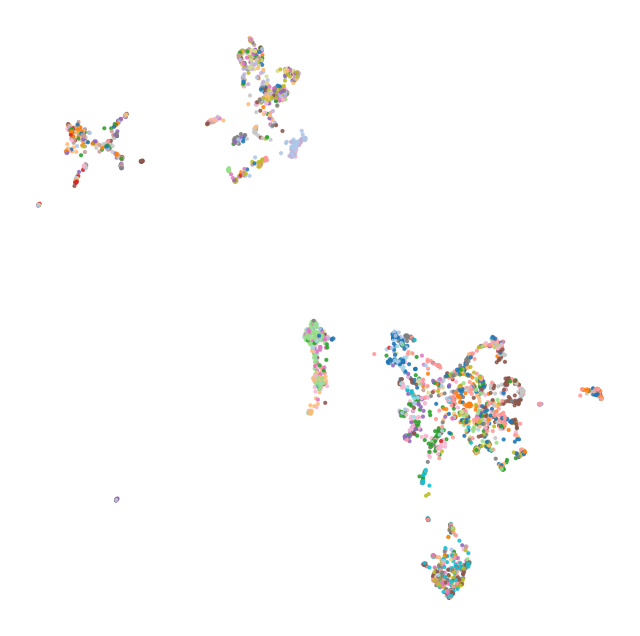

In [ ]:
# vecs_h : (N, d+1) h-weight vectors  (already in memory)
from umap import UMAP                       # pip install umap-learn
import matplotlib.pyplot as plt
from numba import njit

@njit(fastmath=True)
def neg_dot(a, b):
  return -float(np.dot(a, b))

# umap2d = UMAP(n_components=2, metric=neg_dot, random_state=42).fit_transform(vecs_h)

colors = partitions[0].cpu().numpy()        # 68-cluster colouring

plt.figure(figsize=(8,8))
plt.scatter(umap2d[:,0], umap2d[:,1],
            c=colors, s=4, cmap="tab20", alpha=0.8)
plt.axis("off");  #plt.title("UMAP fire-work")
plt.show()


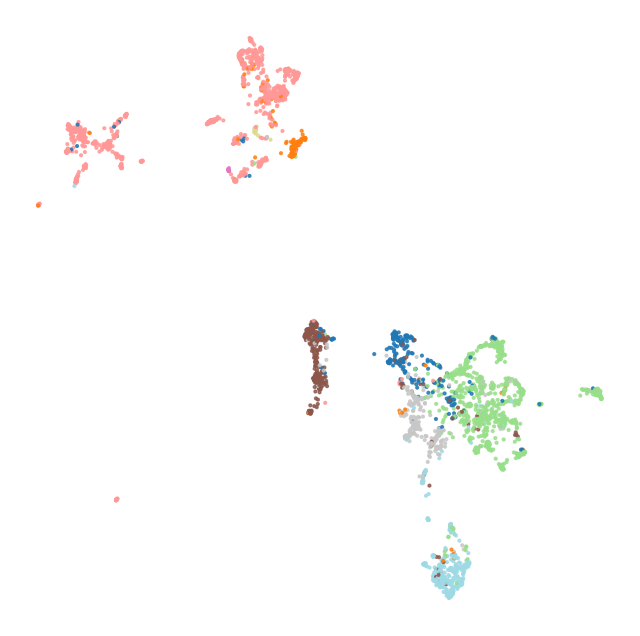

In [ ]:
colors = final_partition.cpu().numpy()        # 68-cluster colouring

plt.figure(figsize=(8,8))
plt.scatter(umap2d[:,0], umap2d[:,1],
            c=colors, s=4, cmap="tab20", alpha=0.8)
plt.axis("off");  #plt.title("UMAP fire-work")
plt.show()

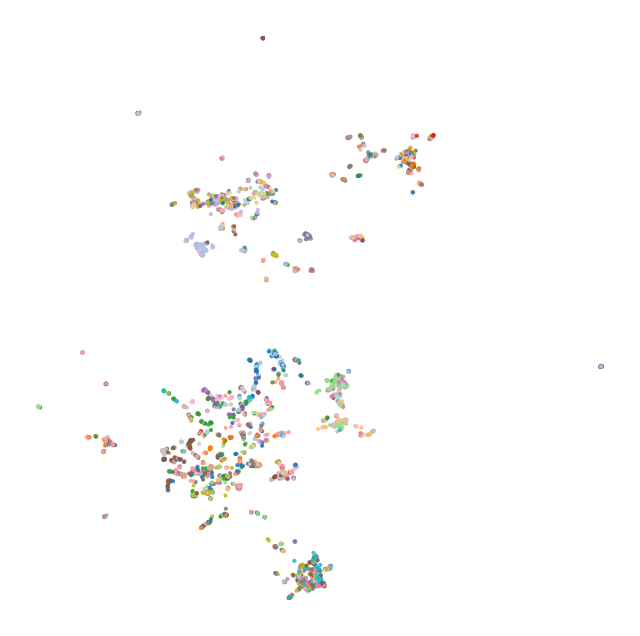

In [ ]:
# umap2d_new = UMAP(n_components=2, metric='cosine', random_state=42).fit_transform(vecs)

colors = partitions[0].cpu().numpy()        # 68-cluster colouring

plt.figure(figsize=(8,8))
plt.scatter(umap2d_new[:,0], umap2d_new[:,1],
            c=colors, s=4, cmap="tab20", alpha=0.8)
plt.axis("off");  #plt.title("UMAP fire-work")
plt.show()

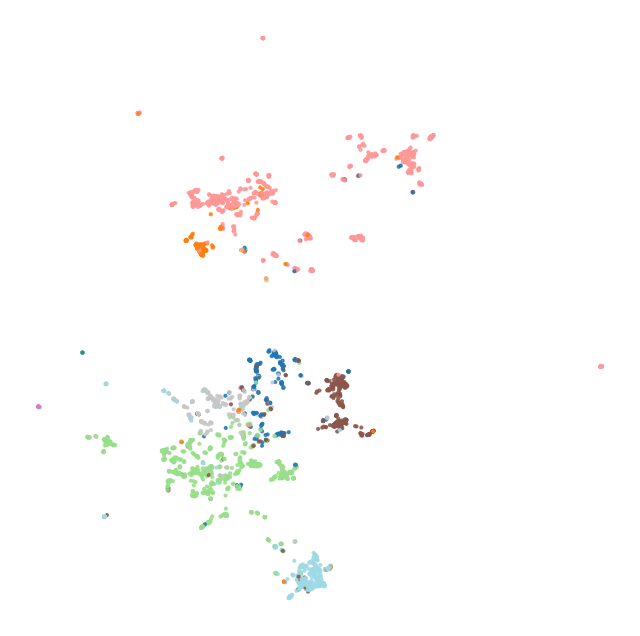

In [ ]:
colors = final_partition.cpu().numpy()        # 68-cluster colouring

plt.figure(figsize=(8,8))
plt.scatter(umap2d_new[:,0], umap2d_new[:,1],
            c=colors, s=4, cmap="tab20", alpha=0.8)
plt.axis("off");  #plt.title("UMAP fire-work")
plt.show()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!pip install json-repair -q

In [ ]:
######################################################################
#  MAP-REDUCE SUMMARISATION USING *partitions* + docs                #
#  ----------------------------------------------------------------- #
#  • docs           : list[dict]  each with  docs[i]["page_content"]  #
#  • partitions     : list[torch.Tensor]  (len = levels + 1)         #
#                     partitions[L][node_idx] -> community id        #
#                     *skip the last tensor* (identity mapping)      #
#  • llm            : async-capable LangChain chat model (ainvoke)   #
######################################################################
from json_repair import repair_json
# If the string was super broken this will return an empty string
import torch, asyncio, json, random, os, tqdm, nest_asyncio, math
nest_asyncio.apply()

MAX_PASSAGES   = 10                       # how many passages per batch
SUMMARY_CACHE  = "community_reports.json"

# SYSTEM_PROMPT = (
#     "You are an expert synthesis engine.\n\n"
#     "TASK\n"
#     "• Read the passages provided below (they may discuss different facts under one topic).\n"
#     "• Write **exactly two complete sentences** (no bullets, no lists, no headings).\n"
#     "• Capture the overarching topic and the most important shared insights.\n"
#     "• Do **not** copy text verbatim; paraphrase in your own words.\n"
#     "• Base the summary **only** on information present in the passages.\n"
#     "• Avoid speculation, opinion, or source citations.\n"
#     "• Keep each sentence under 35 tokens; use clear, neutral language.\n\n"
#     "PASSAGES\n"
#     "{{content}}\n\n"
#     "OUTPUT\n"
#     "Two sentences only."
# )

SYSTEM_PROMPT = (
    "---ROLE---\n"
    "You are an expert synthesis assistant.  Your job is to read a set of very\n"
    "short, topically related text-chunks (≈60 tokens each) and produce a\n"
    "concise yet information-dense **community report** that will guide higher-\n"
    "level retrieval later on.\n"
    "\n"
    "---GOALS---\n"
    "1. Identify the overarching topic that links the chunks.\n"
    "2. Surface the most important, **distinct** insights spread across the\n"
    "   chunks (not just the loudest or earliest).\n"
    "3. Write in clear, neutral prose; do **not** copy passages verbatim.\n"
    "4. Base every statement strictly on content present in the chunks; no\n"
    "   speculation or external facts.\n"
    "5. Keep the total output ≤ 180 tokens so it fits comfortably in\n"
    "   higher-level prompts.\n"
    "\n"
    "---OUTPUT STRUCTURE (JSON)---\n"
    "{\n"
    '  "title": <short phrase capturing the core topic>,\n'
    '  "summary": <2-3 sentence executive overview (≤ 45 tokens each)>,\n'
    '  "key_points": [\n'
    "    {\"point\": <insight 1, ≤ 25 tokens>, \"chunks\": [idx, idx, ...]},\n"
    "    {\"point\": <insight 2>,               \"chunks\": [...]},\n"
    "    ... up to 8 points ...\n"
    "  ]\n"
    "}\n"
    "\n"
    "*   The **title** should be specific (include a central entity, event, or\n"
    "    concept if possible).\n"
    "*   The **summary** should state how the chunks relate to one another and\n"
    "    why the community matters.\n"
    "*   Each **key_point** must be a _different_ aspect or fact; list the chunk\n"
    "    indices (0-based) that support it so downstream steps can trace back.\n"
    "*   Do **not** invent chunk indices; if support spans many chunks, list the\n"
    "    most representative 3-5 and add \"+more\".\n"
    "\n"
    "---INPUT CHUNKS---\n"
    "{{content}}\n"
    "\n"
    "---OUTPUT---\n"
    "Return **only** the JSON object described above, with double quotes and\n"
    "no additional commentary.\n"
)


# --------------------------------------------------
# 1. helper: build communities_by_level from partitions
# --------------------------------------------------
communities_by_level = {}
for L, assign in enumerate(partitions[:-1]):          # skip identity layer
    level_map = {}
    for node_idx, cid in enumerate(assign.tolist()):
        level_map.setdefault(cid, []).append(node_idx)
    communities_by_level[L] = level_map

# --------------------------------------------------
# 2. async LLM helpers
# --------------------------------------------------
async def summarise_batch(texts: list[str]) -> str:
    prompt = SYSTEM_PROMPT.replace("{{content}}", "\n\n".join(texts))
    resp   = await llm.ainvoke(prompt)
    return repair_json(resp.content.strip())

async def summarise_recursive(ids: list[int]) -> str:
    """Recursive map-reduce until the group fits in one LLM call."""
    if len(ids) <= MAX_PASSAGES:                       # base case
        return await summarise_batch([docs[i]["page_content"] for i in ids])

    sub_summaries = []
    for start in range(0, len(ids), MAX_PASSAGES):
        batch_ids = ids[start:start+MAX_PASSAGES]
        sub_summaries.append(
            await summarise_batch([docs[i]["page_content"] for i in batch_ids])
        )
    # reduce: summarise the sub-summaries
    return await summarise_recursive(list(range(len(sub_summaries)))) \
           if all(isinstance(x, int) for x in sub_summaries) else \
           await summarise_batch(sub_summaries)

# --------------------------------------------------
# 3. main driver
# --------------------------------------------------
if os.path.exists(SUMMARY_CACHE):
    community_reports = json.load(open(SUMMARY_CACHE))
else:
    community_reports = {}                 # key = "L:cid" -> summary str

async def generate_all_summaries():
    tasks = []
    for L, coms in communities_by_level.items():
        for cid, ids in coms.items():
            key = f"{L}:{cid}"
            if key not in community_reports:
                tasks.append((key, ids))

    async def worker(key, ids):
        community_reports[key] = await summarise_recursive(ids)

    coros = [worker(k, ids) for k, ids in tasks]
    for fut in tqdm.tqdm(asyncio.as_completed(coros), total=len(coros),
                         desc="Summarising communities"):
        await fut

    with open(SUMMARY_CACHE, "w") as f:
        json.dump(community_reports, f, indent=2, ensure_ascii=False)

asyncio.run(generate_all_summaries())

print(f"✓ Generated summaries for {len(community_reports)} communities "
      f"(cached in {SUMMARY_CACHE})")

Summarising communities: 100%|██████████| 220/220 [03:35<00:00,  1.02it/s]

✓ Generated summaries for 220 communities (cached in community_reports.json)


In [ ]:
######################################################################
#  GRAPH-STYLE RETRIEVAL & GENERATION (LOCAL  /  GLOBAL)             #
######################################################################
import json, numpy as np, asyncio, random, math
from collections import defaultdict

# -------------------------------------------------------------------
# 0. load artefacts --------------------------------------------------
community_reports = json.load(open("community_reports.json"))

# build communities_by_level again (skip identity layer)
communities_by_level = defaultdict(dict)
for L, assign in enumerate(partitions[:-1]):
    for idx, cid in enumerate(assign.tolist()):
        communities_by_level[L].setdefault(int(cid), []).append(idx)

root_level   = max(communities_by_level)   # L=2 in your case
fine_level   = 0                           # L=0 fine clusters

# embed every community summary once
summary_keys   = list(community_reports)   # "L:cid"
summary_texts  = [community_reports[k] for k in summary_keys]
summary_vecs   = np.asarray(embedder.embed_documents(summary_texts), dtype=np.float32)

key2index = {k:i for i,k in enumerate(summary_keys)}

# helper: get embedding for any summary
def summary_vec(level, cid):
    return summary_vecs[key2index[f"{level}:{cid}"]]

In [ ]:
passage2root = torch.empty(len(partitions[0]), dtype=torch.long)
fine_assign  = partitions[0]
mid_assign   = partitions[1]
root_assign  = partitions[2]

for idx in range(len(passage2root)):
    fine_cid      = int(fine_assign[idx])
    mid_cid       = int(mid_assign[fine_cid])
    passage2root[idx] = int(root_assign[mid_cid])

# --------------------------------------------------
# in answer_global(), replace the current child_ids loop
# --------------------------------------------------
child_ids = [idx for idx in range(len(passage2root)) if passage2root[idx] == cid]

In [ ]:
from transformers import AutoTokenizer

# One-time global tokenizer (same model family as the LLM)
Qwentok = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-7B-Instruct")

LOCAL_PROMPT = (
    "---Role---\n"
    "You answer a question using only the facts found in a handful of short,\n"
    "topically related passages.\n\n"
    "---Goal---\n"
    "• Identify which passages are actually relevant and ignore the rest.\n"
    "• Give a concise answer.  If the passages do not\n"
    "  contain enough information, say 'Insufficient information'.\n"
    "• Preserve the original wording of modal verbs (may / shall / will …).\n\n"
    "---Passages---\n"
    "{context}\n\n"
    "---Question---\n"
    "{query}\n\n"
    "---Answer---"
)

async def answer_local(query: str,
                       k_com: int = 4,     # top communities
                       n_pass: int = 12,   # hard ceiling on passages
                       max_ctx_tokens: int = 7_850):
    """Local search with a strict 7 500-token prompt budget."""
    q_vec = np.asarray(embedder.embed_query(query), dtype=np.float32)

    # ── 1. rank fine-level communities ──────────────────────────────────
    fine_keys = [(fine_level, cid) for cid in communities_by_level[fine_level]]
    sims      = [float(q_vec @ summary_vec(*k)) for k in fine_keys]
    top_cids  = [fine_keys[i][1] for i in np.argsort(sims)[-k_com:][::-1]]

    # ── 2. collect candidate passages & score them ─────────────────────
    candidate_ids = [pid
        for cid in top_cids
        for pid in communities_by_level[fine_level][cid]
    ]
    cand_vecs = np.asarray([vecs[i] for i in candidate_ids], dtype=np.float32)
    d_scores  = q_vec @ cand_vecs.T
    ranked_ids = [candidate_ids[i] for i in np.argsort(d_scores)[::-1]]

    # ── 3. build context under the token budget ────────────────────────
    query_tokens  = len(Qwentok.encode(query))
    budget_left   = max_ctx_tokens - query_tokens
    chosen_passages, tot_tokens = [], 0

    for pid in ranked_ids[:n_pass]:           # respect hard ceiling too
        txt   = docs[pid]["page_content"]
        t_len = len(Qwentok.encode(txt))
        if tot_tokens + t_len > budget_left:
            break
        chosen_passages.append(txt)
        tot_tokens += t_len

    context = "\n\n".join(chosen_passages)
    prompt   = LOCAL_PROMPT.format(query=query, context=context)

    # ── 4. LLM call ────────────────────────────────────────────────────
    return (await llm.ainvoke(prompt)).content.strip()


In [ ]:
# # -------------------------------------------------------------------
# # 1. LOCAL GRAPH-RAG  (pinpoint queries) ----------------------------
# # -------------------------------------------------------------------
# async def answer_local(query, k_com=4, n_pass=12):
#     q_vec  = np.asarray(embedder.embed_query(query), dtype=np.float32)

#     # rank fine-level summaries
#     fine_keys = [(fine_level, cid) for cid in communities_by_level[fine_level]]
#     sims = [float(q_vec @ summary_vec(*k)) for k in fine_keys]
#     top_cids = [fine_keys[i][1] for i in np.argsort(sims)[-k_com:][::-1]]

#     # gather passages
#     candidate_ids = [pid
#         for cid in top_cids
#         for pid in communities_by_level[fine_level][cid]
#     ]
#     cand_vecs   = np.asarray([vecs[i] for i in candidate_ids], dtype=np.float32)
#     d_scores    = q_vec @ cand_vecs.T
#     top_ids     = [candidate_ids[i] for i in np.argsort(d_scores)[-n_pass:][::-1]]

#     context = "\n\n".join(docs[i]["page_content"] for i in top_ids)
#     prompt  = f"{query}\n\n{context}"
#     return (await llm.ainvoke(prompt)).content.strip()

# # -------------------------------------------------------------------
# # 2. GLOBAL GRAPH-RAG  (overview queries) ---------------------------
# # -------------------------------------------------------------------
# root_children = {cid: [] for cid in communities_by_level[root_level]}
# for mid_cid, fine_ids in communities_by_level[1].items():
#     root_cid = int(partitions[2][mid_cid])
#     root_children[root_cid].append(mid_cid)

# # async def answer_global(query, m_root=3):
# #     q_vec = np.asarray(embedder.embed_query(query), dtype=np.float32)

# #     # 1. rank root summaries
# #     root_keys = [(root_level, cid) for cid in communities_by_level[root_level]]
# #     sims = [float(q_vec @ summary_vec(*k)) for k in root_keys]
# #     top_roots = [root_keys[i][1] for i in np.argsort(sims)[-m_root:][::-1]]

# #     partials = []
# #     # 2. MAP stage — use level-1 summaries, not raw passages
# #     for cid in top_roots:
# #         child_summaries = [
# #             community_reports[f"1:{mid_cid}"]
# #             for mid_cid in root_children[cid]
# #         ]
# #         ctx = "\n\n".join(child_summaries)          # ≤ 10 summaries → tiny
# #         part_prompt = (
# #             "Answer the question using ONLY the information below.\n\n"
# #             f"Question: {query}\n\nContext:\n{ctx}"
# #         )
# #         partials.append((await llm.ainvoke(part_prompt)).content.strip())

# #     # 3. REDUCE stage — fuse partial answers
# #     fuse_prompt = (
# #         "Below are partial answers from separate top-level clusters:\n\n"
# #         + "\n\n---\n\n".join(partials)
# #         + f"\n\nMerge them into one comprehensive answer to:\n{query}"
# #     )
# #     return (await llm.ainvoke(fuse_prompt)).content.strip()

# import textwrap

# MAX_CTX_TOK  = 1000          # safety cap for each partial cluster prompt
# BATCH_SIZE   = 4             # child summaries per mini-batch

# async def compress_children(summaries: list[str]) -> str:
#     """Map-reduce: 4→1 sentence until short enough."""
#     cur = summaries
#     while True:
#         if len(cur) == 1:
#             return cur[0]

#         # mini-batch summarisation
#         new = []
#         for i in range(0, len(cur), BATCH_SIZE):
#             chunk = "\n".join(cur[i:i+BATCH_SIZE])
#             prompt = (
#                 "Condense the following text into ONE factual sentence. "
#                 "Retain the most important idea only:\n\n" + chunk
#             )
#             new.append((await llm.ainvoke(prompt)).content.strip())
#         cur = new

#         # stop if concatenation fits
#         if sum(len(s.split()) for s in cur) * 1.2 < MAX_CTX_TOK:
#             return " ".join(cur[:15])    # rare case: cut after 15

# async def answer_global(query, m_root=3):
#     q_vec = np.asarray(embedder.embed_query(query), dtype=np.float32)

#     # 1. rank root summaries
#     root_keys = [(root_level, cid) for cid in communities_by_level[root_level]]
#     sims = [float(q_vec @ summary_vec(*k)) for k in root_keys]
#     top_roots = [root_keys[i][1] for i in np.argsort(sims)[-m_root:][::-1]]

#     partials = []
#     for cid in top_roots:
#         child_summaries = [
#             community_reports[f"1:{mid_cid}"]
#             for mid_cid in root_children[cid]
#         ]
#         ctx = await compress_children(child_summaries)

#         part_prompt = (
#             "Answer the question using ONLY the information below.\n\n"
#             f"Question: {query}\n\nContext:\n{ctx}"
#         )
#         partials.append((await llm.ainvoke(part_prompt)).content.strip())

#     # 3. REDUCE stage
#     fuse_prompt = (
#         "Below are partial answers from separate top-level clusters:\n\n"
#         + "\n\n---\n\n".join(partials)
#         + f"\n\nMerge them into one comprehensive, non-repetitive answer to:\n{query}"
#     )
#     return (await llm.ainvoke(fuse_prompt)).content.strip()

# ─────────────────────────────────────────────────────────────────────────────
# Build *N*-level hierarchy helpers  (works for 2 … ∞ levels)
# ─────────────────────────────────────────────────────────────────────────────
import collections, torch, numpy as np, random

# ❶  Strip the dummy identity level at the end
layers = partitions[:-1]                 # len = L  (L >= 1)

num_levels  = len(layers)                # 0 = leaf passages, L-1 = top root
leaf_level  = 0
root_level  = num_levels - 1
fine_level  = 1 if num_levels > 1 else 0     # summaries stored at level-1

# ❷  communities_by_level[level][cid] → list[node_idx]
communities_by_level = [collections.defaultdict(list) for _ in range(num_levels)]

# fill level-0 directly from docs
for idx in range(len(docs)):
    cid = int(layers[leaf_level][idx])
    communities_by_level[leaf_level][cid].append(idx)

# propagate upward
for lvl in range(1, num_levels):
    child2parent = layers[lvl]           # tensor mapping child-cid → parent-cid
    for child_cid, node_ids in communities_by_level[lvl-1].items():
        parent_cid = int(child2parent[child_cid])
        communities_by_level[lvl][parent_cid].extend(node_ids)

# ❸  parent_children[level][parent_cid] → list[child_cid]
parent_children = [collections.defaultdict(list) for _ in range(num_levels-1)]
for lvl in range(1, num_levels):
    child2parent = layers[lvl]
    for child_cid in torch.unique(layers[lvl-1]).tolist():
        parent_cid = int(child2parent[child_cid])
        parent_children[lvl-1][parent_cid].append(child_cid)

root_children = parent_children[root_level-1]   # top-root → sub-roots


# OPTIONAL helper: gather all leaf passages under any community, any depth
def gather_descendant_passages(parent_cid: int, parent_lvl: int) -> list[int]:
    """Return leaf doc indices reachable from (parent_lvl, parent_cid)."""
    if parent_lvl == 0:
        return communities_by_level[0][parent_cid]
    ids = []
    for child in parent_children[parent_lvl-1][parent_cid]:
        ids.extend(gather_descendant_passages(child, parent_lvl-1))
    return ids

PART_PROMPT_GLOBAL = (
    "---Role---\n"
    "You are focusing on one top-level cluster of summaries.\n\n"
    "---Goal---\n"
    "Write a concise answer (≈1 paragraph) using only the summaries below.\n"
    "If the cluster lacks the answer, say 'Insufficient information'\n\n"
    "---Cluster Summaries---\n"
    "{ctx}\n\n"
    "---Question---\n"
    "{query}\n\n"
    "---Answer---"
)

FUSE_PROMPT_GLOBAL = (
    "---Role---\n"
    "You merge several partial answers into one coherent response.\n\n"
    "---Goal---\n"
    "Combine the useful points, remove overlap, resolve any conflicts, and keep\n"
    "modal verbs untouched.  Be concise; if uncertainty remains, state it.\n\n"
    "---Partial Answers---\n"
    "{partials}\n\n"
    "---Question---\n"
    "{query}\n\n"
    "---Comprehensive Answer---"
)

async def answer_global(query: str, m_root: int = 3):
    q_vec = np.asarray(embedder.embed_query(query), dtype=np.float32)

    # rank top-level communities
    root_keys = [(root_level, cid) for cid in communities_by_level[root_level]]
    sims = [float(q_vec @ summary_vec(*k)) for k in root_keys]
    top_roots = [root_keys[i][1] for i in np.argsort(sims)[-m_root:][::-1]]

    partials = []
    child_level = root_level - 1          # one layer below the root
    for cid in top_roots:
        child_summaries = [
            community_reports[f"{child_level}:{child_cid}"]
            for child_cid in parent_children[child_level][cid]
        ]
        ctx = "\n\n".join(child_summaries)
        # part_prompt = (
        #     "Answer the question using ONLY the information below.\n\n"
        #     f"Question: {query}\n\nContext:\n{ctx}"
        # )
        part_prompt = PART_PROMPT_GLOBAL.format(query=query, ctx=ctx)
        partials.append((await llm.ainvoke(part_prompt)).content.strip())

    # fuse_prompt = (
    #     "Below are partial answers from separate top-level clusters:\n\n"
    #     + "\n\n---\n\n".join(partials)
    #     + f"\n\nMerge them into one comprehensive answer to:\n{query}"
    # )
    fuse_prompt = FUSE_PROMPT_GLOBAL.format(
      partials="\n\n---\n\n".join(partials), query=query)
    return (await llm.ainvoke(fuse_prompt)).content.strip()

from transformers import AutoTokenizer
import numpy as np, heapq, random, asyncio

tok = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-7B-Instruct")
MAX_TOKENS = 7_500               # full prompt cap (query + context)
MAP_MAX    = 500                 # max-tokens for each map call
REDUCE_MAX = 512                 # for the final fuse call

PART_PROMPT_DEEP = (
    "---Role---\n"
    "You summarise a sub-cluster selected from a deep hierarchy.\n\n"
    "---Goal---\n"
    "Produce a brief answer (≈1 paragraph) using only the text below.  Say 'Insufficient information' if the text is insufficient.\n\n"
    "---Sub-cluster Context---\n"
    "{ctx}\n\n"
    "---Question---\n"
    "{query}\n\n"
    "---Answer---"
)

FUSE_PROMPT_DEEP = (
    "---Role---\n"
    "You combine answers from multiple topic clusters across several levels.\n\n"
    "---Goal---\n"
    "Write one concise, consistent answer.  Remove redundancy and highlight any\n"
    "remaining uncertainty.  Preserve modal verbs.\n\n"
    "---Partial Answers---\n"
    "{partials}\n\n"
    "---Question---\n"
    "{query}\n\n"
    "---Comprehensive Answer---"
)

async def answer_global_deep(query: str,
                        m_root: int = 3,          # how many roots to explore
                        k_leaf: int = 40):        # cap on final passages
    """
    1. rank top-level communities by summary-vector similarity
    2. MAP  : recursively drill into their sub-communities until token budget
    3. REDUCE: fuse partial answers into a final answer
    """
    q_vec = np.asarray(embedder.embed_query(query), dtype=np.float32)

    # ── 1️⃣  choose root communities ───────────────────────────────────
    root_keys = [(root_level, cid) for cid in communities_by_level[root_level]]
    sims = [float(q_vec @ summary_vec(*k)) for k in root_keys]
    top_roots = [root_keys[i][1] for i in np.argsort(sims)[-m_root:][::-1]]

    partial_answers = []
    # ------------------------------------------------------------------
    # helper to recursively descend until we hit leaf passages
    # ------------------------------------------------------------------
    async def map_community(cid: int, lvl: int) -> str:
        """Return a partial answer for (lvl,cid) using summaries/passages."""
        context_chunks = []
        budget = MAX_TOKENS // m_root - 100   # coarse split per root

        # drill down breadth-first: start with child summaries
        queue = [(lvl-1, child) for child in parent_children[lvl-1][cid]]
        while queue and budget > 200:
            clvl, ccid = queue.pop(0)
            if clvl == 0:                     # leaf passages
                # score leaf with query and push best few
                leaf_ids = communities_by_level[0][ccid]
                vecs_sub = np.asarray([vecs[i] for i in leaf_ids], dtype=np.float32)
                scores   = q_vec @ vecs_sub.T
                top_idx  = [leaf_ids[i] for i in np.argsort(scores)[-3:][::-1]]
                for pid in top_idx:
                    txt   = docs[pid]["page_content"]
                    tlen  = len(tok.encode(txt))
                    if tlen < budget:
                        context_chunks.append(txt)
                        budget -= tlen
            else:
                summ = community_reports[f"{clvl}:{ccid}"]
                tlen = len(tok.encode(summ))
                if tlen < budget:
                    context_chunks.append(summ)
                    budget -= tlen
                    # enqueue next layer only if room
                    queue.extend([(clvl-1, g) for g in parent_children[clvl-1][ccid]])

        ctx = "\n\n".join(context_chunks)
        # part_prompt = (
        #     "Answer the question using ONLY the information below.\n\n"
        #     f"Question: {query}\n\nContext:\n{ctx}"
        # )
        part_prompt  = PART_PROMPT_DEEP.format(query=query, ctx=ctx)
        return (await llm.ainvoke(
                    part_prompt,
                    max_tokens=MAP_MAX,
                    temperature=0)).content.strip()

    # ── 2️⃣  MAP over each selected root ───────────────────────────────
    for rid in top_roots:
        partial_answers.append(await map_community(rid, root_level))

    # ── 3️⃣  REDUCE  ───────────────────────────────────────────────────
    # fuse_prompt = (
    #     "Below are partial answers from different topic clusters:\n\n"
    #     + "\n\n---\n\n".join(partial_answers)
    #     + f"\n\nMerge them into one comprehensive answer to:\n{query}"
    # )
    fuse_prompt  = FUSE_PROMPT_DEEP.format(
                  partials="\n\n---\n\n".join(partial_answers), query=query)
    return (await llm.ainvoke(
                fuse_prompt,
                max_tokens=REDUCE_MAX,
                temperature=0)).content.strip()




# -------------------------------------------------------------------
# 3.  example usage --------------------------------------------------
# -------------------------------------------------------------------
async def demo():
    query= "Who is the individual associated with the cryptocurrency industry facing a criminal trial on fraud and conspiracy charges, as reported by both The Verge and TechCrunch, and is accused by prosecutors of committing fraud for personal gain?"

    print("LOCAL:", await answer_local(query))

    print("GLOBAL:", await answer_global(query))

    print("GLOBAL-DEEP:", await answer_global_deep(query))

asyncio.run(demo())


LOCAL: The individual associated with the cryptocurrency industry facing a criminal trial on fraud and conspiracy charges is Sam Bankman-Fried. Prosecutors accuse him of committing fraud for personal gain, specifically involving the collapse of his cryptocurrency exchange FTX and the theft of customer funds. Bankman-Fried is facing seven counts of criminal charges, including wire fraud and conspiracy.
GLOBAL: The individual associated with the cryptocurrency industry facing a criminal trial on fraud and conspiracy charges, as reported by both The Verge and TechCrunch, and accused by prosecutors of committing fraud for personal gain is SBF (Sam Bankman-Fried).
GLOBAL-DEEP: Sam Bankman-Fried, the founder of the failed cryptocurrency exchange FTX and Alameda Research, is facing a criminal trial on seven counts of wire fraud and conspiracy. He is accused by prosecutors of committing fraud for personal gain, specifically diverting customer funds to Alameda Research, according to the Securit

In [ ]:
######################################################################
#  Local-vs-Global JSON runs  (retrieval_list left empty)            #
#  ----------------------------------------------------------------- #
#  • Uses answer_local() / answer_global() that now return only      #
#    the generated answer string.                                    #
#  • retrieval_list is [] so retrieval metrics are ignored.          #
######################################################################
from tqdm.auto import tqdm
import asyncio, json, nest_asyncio
nest_asyncio.apply()
from datasets import load_dataset

queries     = load_dataset("yixuantt/MultiHopRAG", "MultiHopRAG", split="train")
batch_size  = 16

# ---------------- wrappers -----------------
async def local_single(row):
    ans = await answer_local(row["query"])           # returns str
    return {
        "query"         : row["query"],
        "model_answer"  : ans,
        "question_type" : row["question_type"],
        "retrieval_list": [],                        # ignored by qa_evaluate.py
        "evidence_list" : row["evidence_list"],
    }

async def global_single(row):
    ans = await answer_global(row["query"])          # returns str
    return {
        "query"         : row["query"],
        "model_answer"  : ans,
        "question_type" : row["question_type"],
        "retrieval_list": [],                        # empty → recall = 0
        "evidence_list" : row["evidence_list"],
    }

# ---------------- async runner -----------------
async def run_pass(task_fn, desc, pos):
    out, batch = [], []
    pbar = tqdm(total=len(queries), desc=desc, position=pos, leave=False,
                dynamic_ncols=True)
    for row in queries:
        batch.append(row)
        if len(batch) == batch_size:
            out.extend(await asyncio.gather(*(task_fn(r) for r in batch)))
            pbar.update(len(batch)); batch.clear()
    if batch:
        out.extend(await asyncio.gather(*(task_fn(r) for r in batch)))
        pbar.update(len(batch))
    pbar.close()
    return out

local_json  = asyncio.run(run_pass(local_single,  "Local-GraphRAG",  pos=0))
global_json = asyncio.run(run_pass(global_single, "Global-GraphRAG", pos=1))

json.dump(local_json,  open("local_run_len_600_limit_50.json",  "w"), indent=2, ensure_ascii=False)
json.dump(global_json, open("global_run_len_600_limit_50.json", "w"), indent=2, ensure_ascii=False)

print("✓ Saved local_run.json and global_run.json")


MultiHopRAG.json:   0%|          | 0.00/5.17M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2556 [00:00<?, ? examples/s]

Local-GraphRAG:   0%|          | 0/2556 [00:00<?, ?it/s]

Global-GraphRAG:   0%|          | 0/2556 [00:00<?, ?it/s]

✓ Saved local_run.json and global_run.json


In [ ]:
async def global_single_deep(row):
    ans = await answer_global_deep(row["query"])          # returns str
    return {
        "query"         : row["query"],
        "model_answer"  : ans,
        "question_type" : row["question_type"],
        "retrieval_list": [],                        # empty → recall = 0
        "evidence_list" : row["evidence_list"],
    }
deep_json = asyncio.run(run_pass(global_single, "Global-GraphRAG-Deep", pos=2))
json.dump(deep_json, open("deep_global_run_len_600_limit_50.json", "w"), indent=2, ensure_ascii=False)

Global-GraphRAG-Deep:   0%|          | 0/2556 [00:00<?, ?it/s]

In [ ]:
await answer_local(queries[1312+15]["query"])
# queries[1312+15]

"The Silicon Valley prodigy recognized since his early twenties, who was reported by Fortune to have been ousted by a board he once chaired, is Sam Altman. He is known for backing a teen's AI startup as per TechCrunch and has been suggested by TechCrunch to have had a contentious relationship with that same board."

In [ ]:
!git clone -q https://github.com/yixuantt/MultiHop-RAG.git

!python MultiHop-RAG/qa_evaluate.py         --file local_run.json

fatal: destination path 'MultiHop-RAG' already exists and is not an empty directory.
100% 2556/2556 [00:00<00:00, 15359.39it/s]
Question Type: inference_query
 Precision: 0.92
 Recall: 0.92
 F1 Score: 0.92
 accuracy: 0.86
Question Type: comparison_query
 Precision: 0.07
 Recall: 0.07
 F1 Score: 0.07
 accuracy: 0.35
Question Type: null_query
 Precision: 0.03
 Recall: 0.03
 F1 Score: 0.03
 accuracy: 0.34
Question Type: temporal_query
 Precision: 0.15
 Recall: 0.15
 F1 Score: 0.15
 accuracy: 0.37
Overall Metrics:
 Precision: 0.36
 Recall: 0.36
 F1 Score: 0.36
 Accuracy: 0.44


In [ ]:
!python MultiHop-RAG/qa_evaluate.py         --file global_run.json

100% 2556/2556 [00:00<00:00, 15404.53it/s]
Question Type: inference_query
 Precision: 0.45
 Recall: 0.45
 F1 Score: 0.45
 accuracy: 0.48
Question Type: comparison_query
 Precision: 0.21
 Recall: 0.21
 F1 Score: 0.21
 accuracy: 0.39
Question Type: null_query
 Precision: 0.25
 Recall: 0.25
 F1 Score: 0.25
 accuracy: 0.40
Question Type: temporal_query
 Precision: 0.42
 Recall: 0.42
 F1 Score: 0.42
 accuracy: 0.46
Overall Metrics:
 Precision: 0.34
 Recall: 0.34
 F1 Score: 0.34
 Accuracy: 0.43


In [ ]:
!python MultiHop-RAG/qa_evaluate.py         # llama_local_run.json

100% 2556/2556 [00:00<00:00, 15155.91it/s]
Question Type: inference_query
 Precision: 0.64
 Recall: 0.64
 F1 Score: 0.64
 accuracy: 0.58
Question Type: comparison_query
 Precision: 0.03
 Recall: 0.03
 F1 Score: 0.03
 accuracy: 0.34
Question Type: null_query
 Precision: 0.04
 Recall: 0.04
 F1 Score: 0.04
 accuracy: 0.34
Question Type: temporal_query
 Precision: 0.11
 Recall: 0.11
 F1 Score: 0.11
 accuracy: 0.36
Overall Metrics:
 Precision: 0.25
 Recall: 0.25
 F1 Score: 0.25
 Accuracy: 0.40


In [ ]:
!python MultiHop-RAG/qa_evaluate.py         # llama_global_run.json

100% 2556/2556 [00:00<00:00, 16049.51it/s]
Question Type: inference_query
 Precision: 0.13
 Recall: 0.13
 F1 Score: 0.13
 accuracy: 0.37
Question Type: comparison_query
 Precision: 0.02
 Recall: 0.02
 F1 Score: 0.02
 accuracy: 0.34
Question Type: null_query
 Precision: 0.00
 Recall: 0.00
 F1 Score: 0.00
 accuracy: 0.33
Question Type: temporal_query
 Precision: 0.04
 Recall: 0.04
 F1 Score: 0.04
 accuracy: 0.34
Overall Metrics:
 Precision: 0.06
 Recall: 0.06
 F1 Score: 0.06
 Accuracy: 0.35
